# Predicting Citi Bike Availability

The Citi Bike app tells us how many bikes there are at a station at a given time. Can we use historical usage data to predict bike availability in the future?

**Hypothesis:**

Future bike availability can be determined based on time of day, season, and type of day. 

**Data Cleaning Approach:**

Transform starttime/stoptime features to hourly intervals, seasons (Summer, Spring, Winter, Fall), and type of day (weekday/weekend).  

**Assumptions:**
1. There are no significant changes in bike usage on different weekdays (eg. Monday has same usage patterns as Friday)
2. There are no significant changes in bike usage within a season (eg. early spring has same usage patterns as late spring)

**To be included:**
1. Holidays as type of day
2. Weather data


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def date_format(dt):
    #Converts to datetime
    try:
        return datetime.datetime.strptime(dt,'%m/%d/%Y %H:%M:%S')
    except:
        return datetime.datetime.strptime(dt,'%m/%d/%Y %H:%M')

In [3]:
df201602 = pd.read_csv('../assets/201602-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201601 = pd.read_csv('../assets/201601-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201512 = pd.read_csv('../assets/201512-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201511 = pd.read_csv('../assets/201511-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201510 = pd.read_csv('../assets/201510-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201509 = pd.read_csv('../assets/201509-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201508 = pd.read_csv('../assets/201508-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201507 = pd.read_csv('../assets/201507-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201506 = pd.read_csv('../assets/201506-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201505 = pd.read_csv('../assets/201505-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201504 = pd.read_csv('../assets/201504-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)
df201503 = pd.read_csv('../assets/201503-citibike-tripdata.csv', parse_dates=['starttime','stoptime'],date_parser=date_format)

In [4]:
#Using Citi Bike data from March 2015 to February 2016
frames = [df201602, df201601, df201512, df201511, df201510, df201509, df201508, df201507, 
          df201506, df201505, df201504, df201503]

In [5]:
df = pd.concat(frames)

In [6]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,461,2016-02-01 00:00:08,2016-02-01 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,40.755273,-73.983169,23292,Subscriber,1966.0,1
1,297,2016-02-01 00:00:56,2016-02-01 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,15329,Subscriber,1977.0,1
2,280,2016-02-01 00:01:00,2016-02-01 00:05:40,3134,3 Ave & E 62 St,40.763126,-73.965269,3141,1 Ave & E 68 St,40.765005,-73.958185,22927,Subscriber,1987.0,1
3,662,2016-02-01 00:01:00,2016-02-01 00:12:02,537,Lexington Ave & E 24 St,40.740259,-73.984092,428,E 3 St & 1 Ave,40.724677,-73.987834,20903,Subscriber,1983.0,2
4,355,2016-02-01 00:01:41,2016-02-01 00:07:36,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,521,8 Ave & W 31 St,40.750967,-73.994442,23228,Subscriber,1978.0,1


In [7]:
df.columns = [i.strip().replace(' ', '_') for i in df.columns]

# Determining number of bikes / bike availability

Looking at the dataset, the biggest issue is that it is missing a feature indicating number of bikes available or if there is a bike available at the station. However, the data does include details on when bikes are parked and removed from a station which could be used to make estimations on bike availability:

In [8]:
#Estimate number of bikes at a given station at any given hour by adding number of bikes parked
#and subtracting number of bikes taken.

bikes_parked = df.groupby(['end_station_name',
                           pd.Grouper(key='stoptime',freq='H')]).size().reset_index()
bikes_taken = df.groupby(['start_station_name',
                          pd.Grouper(key='starttime',freq='H')]).size().reset_index()

bikes_parked.rename(columns={'end_station_name': 'station_name', 
                             'stoptime': 'time',
                             0: 'bikes_parked'}, inplace=True)
bikes_taken.rename(columns={'start_station_name': 'station_name', 
                            'starttime': 'time',
                            0: 'bikes_taken'},inplace=True)

bikes_parked.head()

,station_name,time,bikes_parked
0,1 Ave & E 15 St,2015-03-01 00:00:00,4
1,1 Ave & E 15 St,2015-03-01 01:00:00,1
2,1 Ave & E 15 St,2015-03-01 02:00:00,1
3,1 Ave & E 15 St,2015-03-01 05:00:00,1
4,1 Ave & E 15 St,2015-03-01 09:00:00,4


We now have two dataframes that give us information on number of bikes parked and bikes taken at any given hour. 

The second issue that needs to be addressed is that Citi Bike data does not incorporate staff activity. This means that bikes that are added/removed at certain stations to increase availability of bikes/parking or bikes that are removed for inspection is not included in the dataset. 

We will use bikeid to make estimations on staff activity based on if a bike is parked at one station but was taken out at a different station in the next occurence.

In [9]:
#compare end station with next start station grouping by bikeid
_temp = df.copy()
_temp[['next_station','next_start']] = _temp.groupby('bikeid').shift(-1)[['start_station_name','starttime']]
_temp.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,next_station,next_start
0,461,2016-02-01 00:00:08,2016-02-01 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,40.755273,-73.983169,23292,Subscriber,1966.0,1,W 43 St & 6 Ave,2016-02-01 06:05:29
1,297,2016-02-01 00:00:56,2016-02-01 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,15329,Subscriber,1977.0,1,W 4 St & 7 Ave S,2016-02-01 09:22:39
2,280,2016-02-01 00:01:00,2016-02-01 00:05:40,3134,3 Ave & E 62 St,40.763126,-73.965269,3141,1 Ave & E 68 St,40.765005,-73.958185,22927,Subscriber,1987.0,1,1 Ave & E 68 St,2016-02-01 06:46:52
3,662,2016-02-01 00:01:00,2016-02-01 00:12:02,537,Lexington Ave & E 24 St,40.740259,-73.984092,428,E 3 St & 1 Ave,40.724677,-73.987834,20903,Subscriber,1983.0,2,E 3 St & 1 Ave,2016-02-01 00:25:12
4,355,2016-02-01 00:01:41,2016-02-01 00:07:36,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,521,8 Ave & W 31 St,40.750967,-73.994442,23228,Subscriber,1978.0,1,8 Ave & W 31 St,2016-02-01 05:57:21


With this we are able to determine if a bike was removed/added at a station by the staff (end_station_name != next_station). However, in order to determine bikes available at any given hour at a station we need to estimate when that bike was added to/removed from the station. 

To do so, we made the following assumptions:

**Assumptions:**
1. Staff only add and remove bikes between 8am and 7pm
2. Someone took out a staff added bike in the hour that the staff added bikes
3. The staff took out one of the bikes that a user parked in the same hour

In [10]:
#Count number of times a bike was removed from a station that it was not parked in
staff_added_hour = _temp[_temp['end_station_name'] != _temp['next_station']].fillna(0).groupby(['next_station',
                                                                pd.Grouper(key='next_start',freq='H')]).size().reset_index()
staff_added_hour.rename(columns={0: 'staff_added_hour'},inplace=True)

In [11]:
staff_added_time = [staff_added_hour.next_start[0]]
staff_added_bikes = [staff_added_hour.staff_added_hour[0]]
station_id = [staff_added_hour.next_station[0]]
j = 0

for i in range(len(staff_added_hour)):
    if i != 0:
        if (staff_added_hour.next_start[i].date() != staff_added_hour.next_start[(i-1)].date() 
            and datetime.time(20) > staff_added_hour.next_start[i].time() > datetime.time(7)):
                staff_added_time.append(staff_added_hour.next_start[i])
                staff_added_bikes.append(staff_added_hour.staff_added_hour[i])
                station_id.append(staff_added_hour.next_station[i])
                j += 1
        else:
                staff_added_bikes[j] += staff_added_hour.staff_added_hour[i]
 
        

df_staff_added = pd.DataFrame({'station_name': station_id,
                               'time': staff_added_time,
                               'staff_added': staff_added_bikes})

In [12]:
df_staff_added.head()

,staff_added,station_name,time
0,8493,0,1970-01-01 00:00:00
1,4,1 Ave & E 15 St,2015-03-03 08:00:00
2,3,1 Ave & E 15 St,2015-03-04 12:00:00
3,12,1 Ave & E 15 St,2015-03-06 08:00:00
4,5,1 Ave & E 15 St,2015-03-07 09:00:00


In [13]:
staff_removed_hour = _temp[_temp['end_station_name'] != _temp['next_station']].groupby(['end_station_name',
                                                                pd.Grouper(key='starttime',freq='H')]).size().reset_index()
staff_removed_hour.rename(columns={0: 'staff_removed_hour'},inplace=True)

In [14]:
staff_removed_time = []
staff_removed_bikes = []
station_id = []
count = staff_removed_hour.staff_removed_hour[0]

for i in range(len(staff_removed_hour)):
    if i != len(staff_removed_hour)-1:
        if (staff_removed_hour.starttime[i].date() != staff_removed_hour.starttime[(i+1)].date() 
            and datetime.time(20) > staff_removed_hour.starttime[i].time() > datetime.time(7)):
                staff_removed_time.append(staff_removed_hour.starttime[i])
                staff_removed_bikes.append(count)
                station_id.append(staff_removed_hour.end_station_name[i])
                count = staff_removed_hour.staff_removed_hour[i+1]
        else:
                count += staff_removed_hour.staff_removed_hour[i]


df_staff_removed = pd.DataFrame({'station_name': station_id,
                                 'time': staff_removed_time,
                                 'staff_removed': staff_removed_bikes})

In [15]:
df_staff_removed.head()

,staff_removed,station_name,time
0,4,1 Ave & E 15 St,2015-03-01 12:00:00
1,11,1 Ave & E 15 St,2015-03-03 17:00:00
2,20,1 Ave & E 15 St,2015-03-05 08:00:00
3,57,1 Ave & E 15 St,2015-03-10 18:00:00
4,70,1 Ave & E 15 St,2015-03-15 18:00:00


In [16]:
#create new dataframe with all values
firstdate = df.starttime.min().replace(minute=0, second=0, microsecond=0)
#number of days based on length of data
days = 29+31+31+30+31+30+31+31+30+31+30+31
periods = 24*days

datelist = pd.date_range(firstdate, periods=periods, freq='H').tolist()
stations = df.start_station_name.unique().tolist()
stationlist = [val for val in stations for i in range(periods)]
datelist = datelist * len(stations)
df_freqhours = pd.DataFrame({'station_name': stationlist,
                           'time': datelist})
df_freqhours.head()

,station_name,time
0,W 53 St & 10 Ave,2015-03-01 00:00:00
1,W 53 St & 10 Ave,2015-03-01 01:00:00
2,W 53 St & 10 Ave,2015-03-01 02:00:00
3,W 53 St & 10 Ave,2015-03-01 03:00:00
4,W 53 St & 10 Ave,2015-03-01 04:00:00


In [17]:
#merge dataframes together
df_freqhours2 = pd.merge(df_freqhours, bikes_parked, on=['station_name','time'], how='outer')
df_freqhours3 = pd.merge(df_freqhours2, bikes_taken, on=['station_name','time'], how='outer')
df_freqhours3.fillna(0,inplace=True)
#bike_change is user added bikes minus user removed bikes
df_freqhours3['bike_change'] = df_freqhours3.bikes_parked - df_freqhours3.bikes_taken
df_freqhours4 = pd.merge(df_freqhours3, df_staff_added, on=['station_name','time'], how='outer' )
df_freqhours5 = pd.merge(df_freqhours4, df_staff_removed, on=['station_name','time'], how='outer' )
df_freqhours5.fillna(0,inplace=True)
#staff_change is staff added bikes minus staff removed bikes
df_freqhours5['staff_change'] = df_freqhours5.staff_added - df_freqhours5.staff_removed

In [18]:
df_freqhours5.head()

,station_name,time,bikes_parked,bikes_taken,bike_change,staff_added,staff_removed,staff_change
0,W 53 St & 10 Ave,2015-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,W 53 St & 10 Ave,2015-03-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,W 53 St & 10 Ave,2015-03-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,W 53 St & 10 Ave,2015-03-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,W 53 St & 10 Ave,2015-03-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0


The next step is to determine reset points of which there were 0 bikes available. The reasons for this are: 1) it will allow us to add bike_change and staff_change from those points onwards 2) allows for reset points to mitigate error from assumptions.

To determine these reset points, we make the following assumption:

**Assumption:**
Between (and including) 7am to 11pm, if looking x hours back, staff and users did not add any bikes and if looking y hours after, users and staff did not remove any bikes we assume that there were no bikes at that time. 

In [19]:
#Function that sums up change looking back or after x hours for a feature and creates a column with total change
def add_shift_x(df, shiftamnt,shifttype):
    amnt = shiftamnt
    while shiftamnt != 0:
        if shiftamnt > 0:
            df[shifttype+'_after_'+str(shiftamnt)] = df.groupby('station_name').shift(shiftamnt)[shifttype]
            shiftamnt-=1
        else:
            df[shifttype+'_before_'+str(abs(shiftamnt))] = df.groupby('station_name').shift(shiftamnt)[shifttype]
            shiftamnt+=1
    df[shifttype+'at_0'] = df.groupby('station_name').shift(0)[shifttype]
    if amnt > 0:
        df['total_'+shifttype+'_after'] = df[df.columns[-amnt:]].sum(axis=1)
        df = df.drop(df[df.columns[(-amnt-2):-1]], axis = 1)
    elif amnt < 0:
        df['total_'+shifttype+'_before'] = df[df.columns[amnt:]].sum(axis=1)
        df = df.drop(df[df.columns[(amnt-2):-1]], axis = 1)
    return df

In [20]:
has_bikes = df_freqhours5.drop(['bikes_parked','bikes_taken', 'staff_added', 'staff_removed'], axis=1)

In [21]:
#Assumption: Looking 2 hours back, looking 1 hour after
has_bikes = add_shift_x(has_bikes, 1, 'bike_change')
has_bikes = add_shift_x(has_bikes, 1, 'staff_change')
has_bikes = add_shift_x(has_bikes,-2,'bike_change')
has_bikes = add_shift_x(has_bikes,-2,'staff_change')

In [22]:
has_bikes.head()

,station_name,time,bike_change,staff_change,total_bike_change_after,total_staff_change_after,total_bike_change_before,total_staff_change_before
0,W 53 St & 10 Ave,2015-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,W 53 St & 10 Ave,2015-03-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,W 53 St & 10 Ave,2015-03-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,W 53 St & 10 Ave,2015-03-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,W 53 St & 10 Ave,2015-03-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
hasbike = []
for i in range(len(has_bikes)):
    if has_bikes.time[i].time() > datetime.time(6):
        if (has_bikes.total_bike_change_after[i] >= 0 
            and has_bikes.total_staff_change_after[i] >=0
            and has_bikes.total_bike_change_before[i] <= 0 
            and has_bikes.total_staff_change_before[i] <= 0):
            hasbike.append(0)
        else:
            hasbike.append(1)
    else:
        hasbike.append(1)

In [24]:
hasbike = pd.DataFrame({'has_bike': hasbike})

In [25]:
has_bikes = df_freqhours5.drop(['bikes_parked','bikes_taken', 'staff_added', 'staff_removed'], axis=1)

In [26]:
has_bikes['total_change'] = has_bikes[['bike_change','staff_change']].sum(axis=1)
has_bikes = has_bikes.join(hasbike)

In [27]:
has_bikes.head()

,station_name,time,bike_change,staff_change,total_change,has_bike
0,W 53 St & 10 Ave,2015-03-01 00:00:00,0.0,0.0,0.0,1
1,W 53 St & 10 Ave,2015-03-01 01:00:00,0.0,0.0,0.0,1
2,W 53 St & 10 Ave,2015-03-01 02:00:00,0.0,0.0,0.0,1
3,W 53 St & 10 Ave,2015-03-01 03:00:00,0.0,0.0,0.0,1
4,W 53 St & 10 Ave,2015-03-01 04:00:00,0.0,0.0,0.0,1


With this, we now have reset points where has_bike = 0. The next step is to change starttime/stoptime to categorical variables:

In [28]:
Spring = range(3,6)
Summer = range(6,9)
Fall = range(9,12)
Winter = [12]+range(1,3)
Weekday = range(0,5)
Weekend = range(5,7)

In [29]:
def season(column):
    if column.month in Winter:
        return 'Winter'
    elif column.month in Spring:
        return 'Spring'
    elif column.month in Summer:
        return 'Summer'
    elif column.month in Fall:
        return 'Fall'
    else:
        return 'Error'

In [30]:
def typeofday(column):
    if column.weekday() in Weekday:
        return 'Weekday'
    elif column.weekday() in Weekend:
        return 'Weekend'
    else:
        return 'Error'

In [31]:
new_df = has_bikes.copy()
new_df['season'] = map(season, new_df.time)
new_df['typeofday'] = map(typeofday, new_df.time)
new_df['timeofday'] = new_df.time.dt.hour
new_df.head()

,station_name,time,bike_change,staff_change,total_change,has_bike,season,typeofday,timeofday
0,W 53 St & 10 Ave,2015-03-01 00:00:00,0.0,0.0,0.0,1,Spring,Weekend,0
1,W 53 St & 10 Ave,2015-03-01 01:00:00,0.0,0.0,0.0,1,Spring,Weekend,1
2,W 53 St & 10 Ave,2015-03-01 02:00:00,0.0,0.0,0.0,1,Spring,Weekend,2
3,W 53 St & 10 Ave,2015-03-01 03:00:00,0.0,0.0,0.0,1,Spring,Weekend,3
4,W 53 St & 10 Ave,2015-03-01 04:00:00,0.0,0.0,0.0,1,Spring,Weekend,4


# Seperate data on different stations

In [32]:
df_Allen_Hester = new_df[new_df.station_name == 'Allen St & Hester St'].reset_index(drop=True)

For each station, we will apply total_change to any point after each reset point. The reason we do this after seperating out stations is to avoid overlap when the dataframe transitions from one station to another. 

Note: This was not necessary when determining reset points because reset points only were applied to times after 7pm and transitions between stations started from midnight. 

In [33]:
#Count number of bikes based on reset points when bike=0
def createbikelist(df):
    numberofbikes = []
    for i in range(len(df)):
        if df.has_bike[i] == 0:
            numberofbikes.append(0)
        else:
            if i != 0:
                numberofbikes.append(numberofbikes[i-1]+df.total_change[i])
            else:
                numberofbikes.append(df.total_change[i])
    numberofbikes = pd.DataFrame({'number_of_bikes': numberofbikes})
    return numberofbikes

In [34]:
numberofbikes = createbikelist(df_Allen_Hester)

In [35]:
df_Allen_Hester = df_Allen_Hester.join(numberofbikes)

In [36]:
#If number_of_bikes returns a negative value, consider it to have no bikes available. 
def new_has_bike(dfcolumn):
    if dfcolumn >= 0:
        return 1
    else:
        return 0

In [37]:
df_Allen_Hester['has_bike'] = map(new_has_bike, df_Allen_Hester.number_of_bikes)

In [38]:
_temp = df_Allen_Hester[['station_name','timeofday','season','typeofday','has_bike']]

In [39]:
_temp.head()

,station_name,timeofday,season,typeofday,has_bike
0,Allen St & Hester St,0,Spring,Weekend,1
1,Allen St & Hester St,1,Spring,Weekend,1
2,Allen St & Hester St,2,Spring,Weekend,1
3,Allen St & Hester St,3,Spring,Weekend,1
4,Allen St & Hester St,4,Spring,Weekend,1


In [40]:
#create dummy variables for the categorical variables
dummiesday = pd.get_dummies(_temp['typeofday'],'is')
dummiesmonth = pd.get_dummies(_temp['season'],'is')
_temp = pd.concat([_temp, dummiesday], axis=1)
_temp = pd.concat([_temp, dummiesmonth], axis=1)
_temp.drop(['is_Weekend', 'is_Winter'], inplace=True, axis=1)

In [41]:
df = _temp.copy()
df.head()

,station_name,timeofday,season,typeofday,has_bike,is_Weekday,is_Fall,is_Spring,is_Summer
0,Allen St & Hester St,0,Spring,Weekend,1,0.0,0.0,1.0,0.0
1,Allen St & Hester St,1,Spring,Weekend,1,0.0,0.0,1.0,0.0
2,Allen St & Hester St,2,Spring,Weekend,1,0.0,0.0,1.0,0.0
3,Allen St & Hester St,3,Spring,Weekend,1,0.0,0.0,1.0,0.0
4,Allen St & Hester St,4,Spring,Weekend,1,0.0,0.0,1.0,0.0


# Logistic Regression 

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lm = LogisticRegression()
X = df[['timeofday','is_Weekday','is_Fall','is_Summer','is_Spring']]
y = df.has_bike
lm.fit(X, y)
print "Logistic Regression Score:", lm.score(X,y)

Logistic Regression Score: 0.615095628415


In [44]:
df_lm = _temp.copy()
df_lm['probability'] = lm.predict_proba(X)[:,1]

In [45]:
groups = df_lm.groupby('is_Weekday')

In [46]:
groups2 = df_lm.groupby(['typeofday','season'])

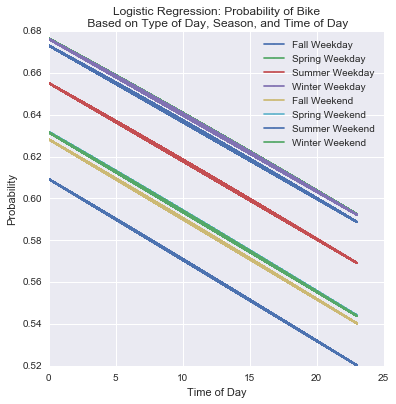

In [47]:
#Graphing out probability of a bike being available
days = {('Weekday','Fall'): 'Fall Weekday', ('Weekend','Fall'): 'Fall Weekend', 
        ('Weekday','Summer'): 'Summer Weekday', ('Weekend','Summer'): 'Summer Weekend', 
        ('Weekday','Spring'): 'Spring Weekday', ('Weekend','Spring'): 'Spring Weekend', 
        ('Weekday','Winter'): 'Winter Weekday', ('Weekend','Winter'): 'Winter Weekend'}

fig, ax = plt.subplots(figsize=(6,6))
for name, group in groups2:
    ax.plot(group.timeofday, group.probability, marker='o', markersize=1, linestyle='-', label=days[name])
ax.legend(loc='upper right')
plt.title('Logistic Regression: Probability of Bike\n Based on Type of Day, Season, and Time of Day')
plt.ylabel('Probability')
plt.xlabel('Time of Day')
plt.show()

# Cross Validation

In [48]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
params = {'weights':['distance'], 'n_neighbors': range(1,100,2)}
kf = KFold(len(df),n_folds = 10)
cv = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    cv = kf,
)
cv.fit(X,y)
_ = cv.grid_scores_

In [49]:
print cv.best_params_
print "Cross Validation score:",cv.best_score_

{'n_neighbors': 29, 'weights': 'distance'}
Cross Validation score: 0.627276867031


# Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier(n_estimators=20,max_depth=5,min_samples_leaf=50)
rf.fit(X,y)
probs = rf.predict_proba(X)[:,1]
print 'Random Forest Classifier Score:', rf.score(X,y)
print 'Random Forest Classifier Area under Curve:', roc_auc_score(y,probs)

Random Forest Classifier Score: 0.652436247723
Random Forest Classifier Area under Curve: 0.669413286724


In [52]:
df_rf = df.copy()

In [53]:
df_rf['probability'] = rf.predict_proba(X)[:,1]
groups3 = df_rf.groupby(['typeofday','season'])

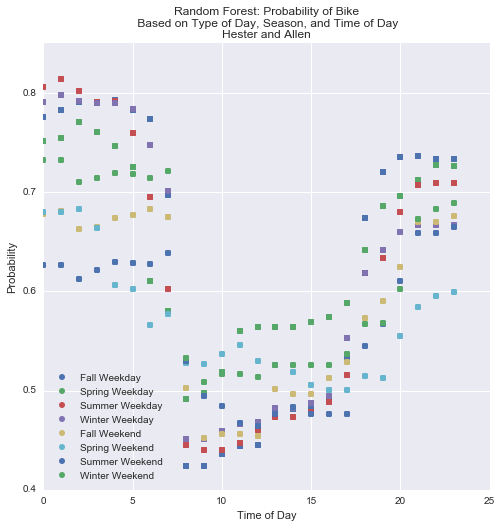

In [54]:
#Graphing out probability of a bike being available
days = {('Weekday','Fall'): 'Fall Weekday', ('Weekend','Fall'): 'Fall Weekend', 
        ('Weekday','Summer'): 'Summer Weekday', ('Weekend','Summer'): 'Summer Weekend', 
        ('Weekday','Spring'): 'Spring Weekday', ('Weekend','Spring'): 'Spring Weekend', 
        ('Weekday','Winter'): 'Winter Weekday', ('Weekend','Winter'): 'Winter Weekend'}

fig, ax = plt.subplots(figsize=(8,8))
for name, group in groups3:
    ax.plot(group.timeofday, group.probability, marker='o', markersize=6, linestyle='', label=days[name])
ax.legend(loc='lower left')
plt.title('Random Forest: Probability of Bike\n Based on Type of Day, Season, and Time of Day\nHester and Allen')
plt.ylabel('Probability')
plt.xlabel('Time of Day')
plt.show()

# Conclusions

With the different models we can make predictions on if there is a bike available:

In [55]:
print "Bike availability predictions for 10am on a Weekday in the Summer:"
print "Linear model prediction:", lm.predict([10,1,0,1,0])
print "Cross validation model prediction:", cv.predict([10,1,0,1,0])
print "Random forest model prediction:", rf.predict([10,1,0,1,0])

Bike availability predictions for 10am on a Weekday in the Summer:
Linear model prediction: [1]
Cross validation model prediction: [0]
Random forest model prediction: [0]


/Users/JToyoshima/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/JToyoshima/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/JToyoshima/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

There are various improvements that can be made to the models which include incorporating weather data, seperating out holidays, and considering nearby stations bike availability.

The biggest concern of the project is that the dependent outcome (bike availability) was determined by estimations and assumptions. This can be improved by training over live data (https://feeds.citibikenyc.com/stations/stations.json) and tweaking assumptions made.